# Notebook 23: Analysis through He burning 2

In this notebook we look at a few variations of stars run through Helium burning. The main stopping condition is the central He4 fraction dropping below $10^{-6}$, which also allows for carbon ignition. There are two additional conditions to catch and stop system that a) go into critical rotation and do not "recover"; and b) are confindently non-CHE.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 23

## Imports

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
PROJECT_FOLDER = ROOT/'mesa/sse_wind_test'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [5]:
ZSUN = 0.014

### Utilities

In [6]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [7]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [8]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [9]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication and division."""
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [11]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
            except:
                continue
            else:
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

### Winds

In [12]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [13]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [14]:
vink2001_test_teffs = np.logspace(3, 6, 100)
vink2001_test_mdots = vink2001_winds(1e6, vink2001_test_teffs, 60, ZSUN)

(6.0, 3.0)

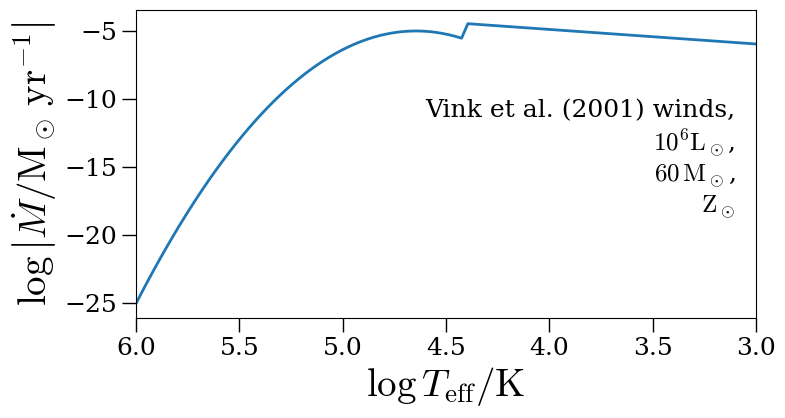

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.log10(vink2001_test_teffs), np.log10(vink2001_test_mdots))

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\\left|\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}\\right|$')
ax.text(
    3.1,
    -10,
    ',\n'.join((
        'Vink et al. (2001) winds',
        '$10^{6}\\mathrm{L}_\\odot$',
        '$60\\,\\mathrm{M}_\\odot$',
        '$\\mathrm{Z}_\\odot$'
        )),
    ha='right',
    va='top',
    fontsize=18,
    transform=ax.transData
)
ax.set_xlim(6, 3)

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## Humphreys-Davidson limit

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

# Analysis

Models run through helium burning are identified by a first digit 1 in the project folder. All use $Y_0=0.4$ and $\delta Y=0.3$.

In [20]:
model_ids = ['20', '21', '22', '23', '24', '25', '26']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$40\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$',
    '$50\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$',
    '$60\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$',
    '$70\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$',
    '$50\,\\mathrm{M}_\\odot,\\,Z_\\odot/15,\\Delta_\\mathrm{mesh}$',
    '$50\,\\mathrm{M}_\\odot,\\,Z_\\odot/20,\\Delta_\\mathrm{mesh}$',
    '$50\,\\mathrm{M}_\\odot,\\,Z_\\odot/30,\\Delta_\\mathrm{mesh}$',
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/20_md1_m40_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/21_md1_m50_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/22_md1_m60_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/23_md1_m70_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/24_md1_m50_0066zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/25_md1_m50_005zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/26_md1_m50_0033zsun_04y0_03dy_HeExh


Let's check the stellar models available.

In [21]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/20_md1_m40_01zsun_04y0_03dy_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/21_md1_m50_01zsun_04y0_03dy_HeExh:
		(m1/msun) 50.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/22_md1_m60_01zsun_04y0_03dy_HeExh:
		(m1/msun) 60.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/23_md1_m70_01zsun_04y0_03dy_HeExh:
		(m1/msun) 70.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/24_md1_m50_0066zsun_04y0_03dy_HeExh:
		(m1/msun) 50.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d)

### The effect of mass

Let's first look at the evolution of our systems in the HR diagram.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


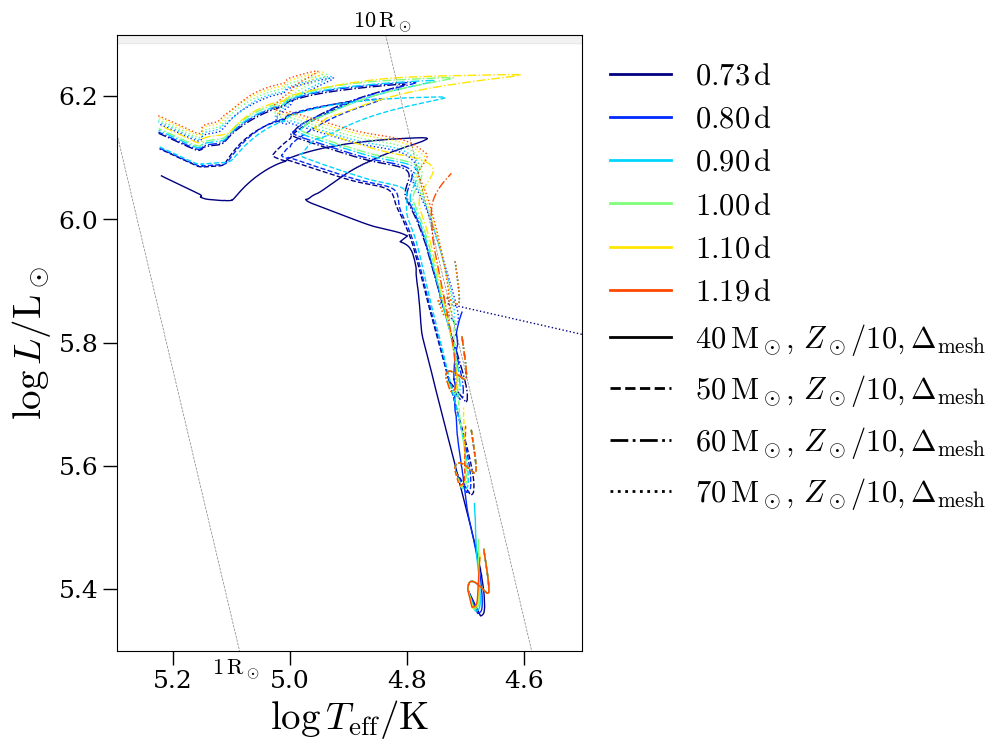

In [22]:

fig, ax = plt.subplots(figsize=(6, 8))

# Plot 1, Zsun/10

models_to_plot = [0, 1, 2, 3]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', '-.', ':']

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

# GUIDELINES

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Humphreys-Davidson limit and LBV regime
hd_x = np.linspace(*xlim, 100)
hd_y = hd_limit(hd_x)
ax.plot(hd_x, hd_y, 'k--', lw=1)
ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)
#ax.text(4, 6.2, 'LBV', ha='center', va='top', fontsize=22, transform=ax.transData)

xlim = (xlim[0], 4.5)
ylim = (5.3, 6.3)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Lines of constant radius
r = 1
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='top', fontsize=16)
r = 10
ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
ax.text(hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))], ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$', ha='center', va='bottom', fontsize=16)

savefig(fig, 'hr_allp_mass_comparison')

In [23]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r = 1
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 5
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 8
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 10
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))],
        ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center', 
        va='bottom', 
        fontsize=16
        )
    r = 20
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))],
        ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center', 
        va='bottom', 
        fontsize=16
        )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


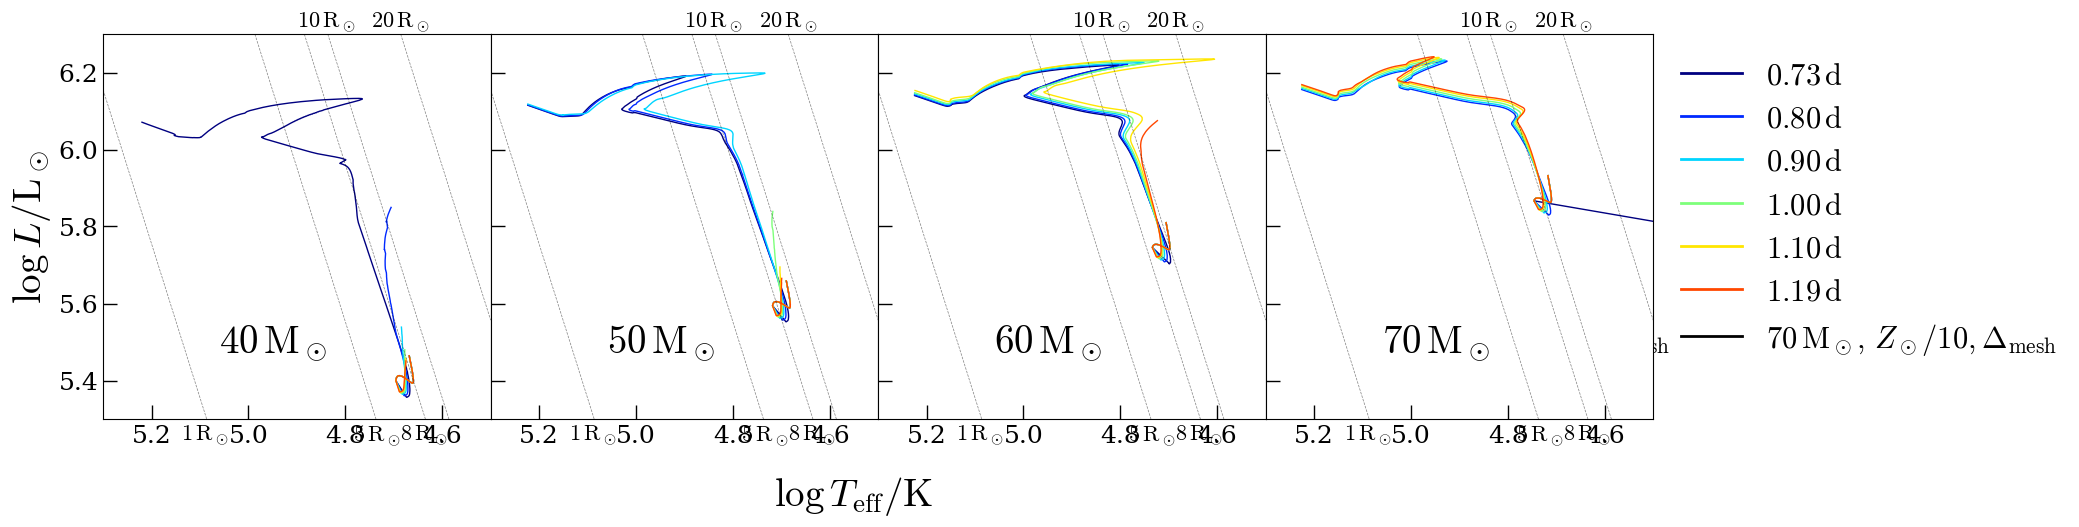

In [24]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(wspace=0)

xlim = (5.3, 4.5)
ylim = (5.3, 6.3)

# PLOT M=40
ax = axes[0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=60
ax = axes[2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=70
ax = axes[3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

#######################################

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')

savefig(fig, 'hr_allp_mass_comparison')

What does the core look like at the end? Let's look at an example case.

In [25]:
test_case = model_dicts[0]['40.0']['0.73']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(0.0, 41.99999854682715)

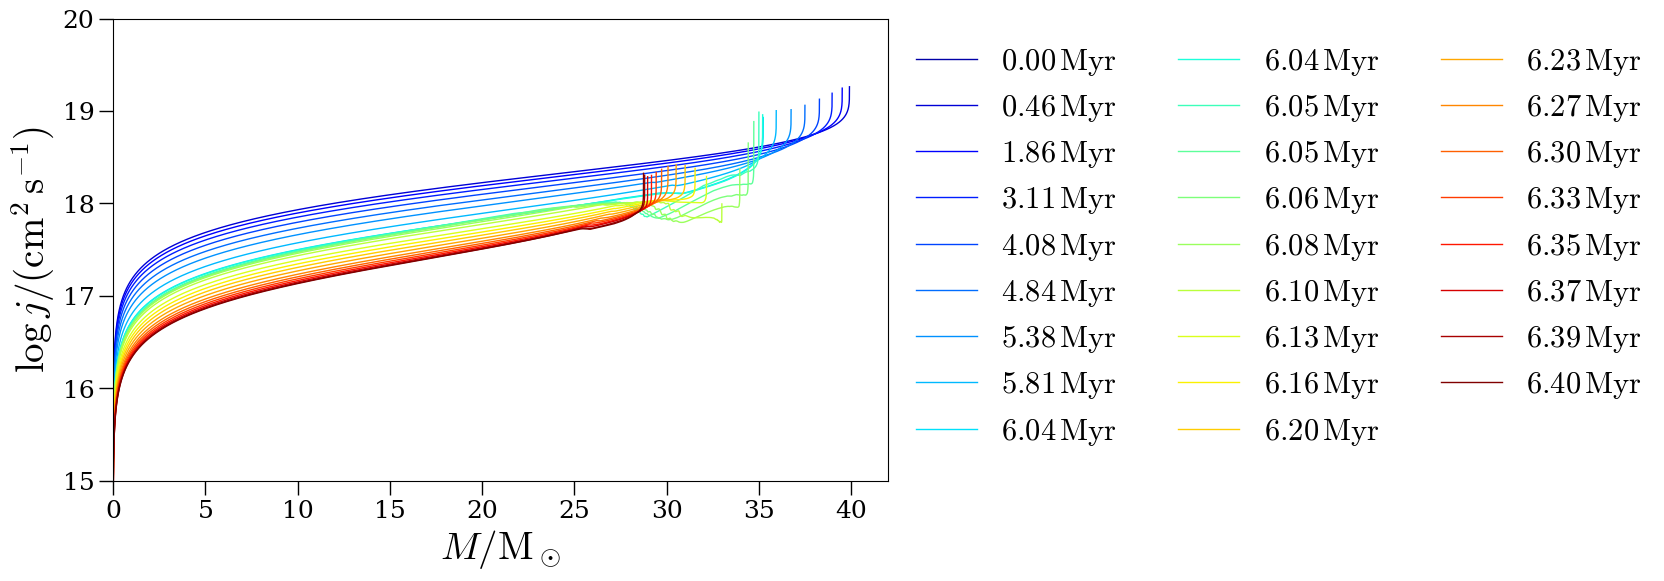

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_j_rot, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log j/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
ax.set_ylim(15, 20)
ax.set_xlim(0)
    

In [27]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[0]['40.0']['0.73']/'LOGS'))
#mm.scrubHistory()

2387.0


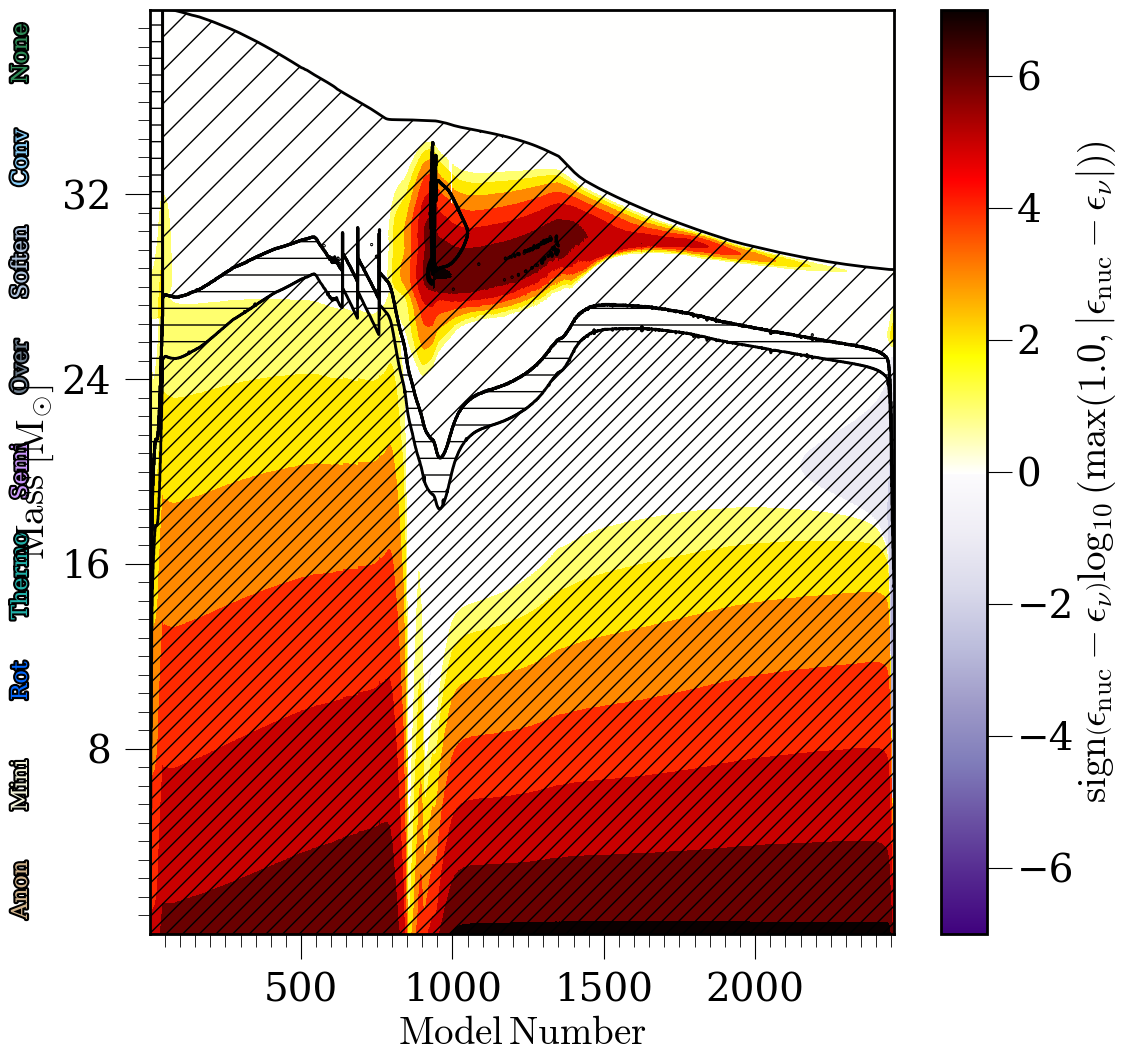

In [28]:
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True)

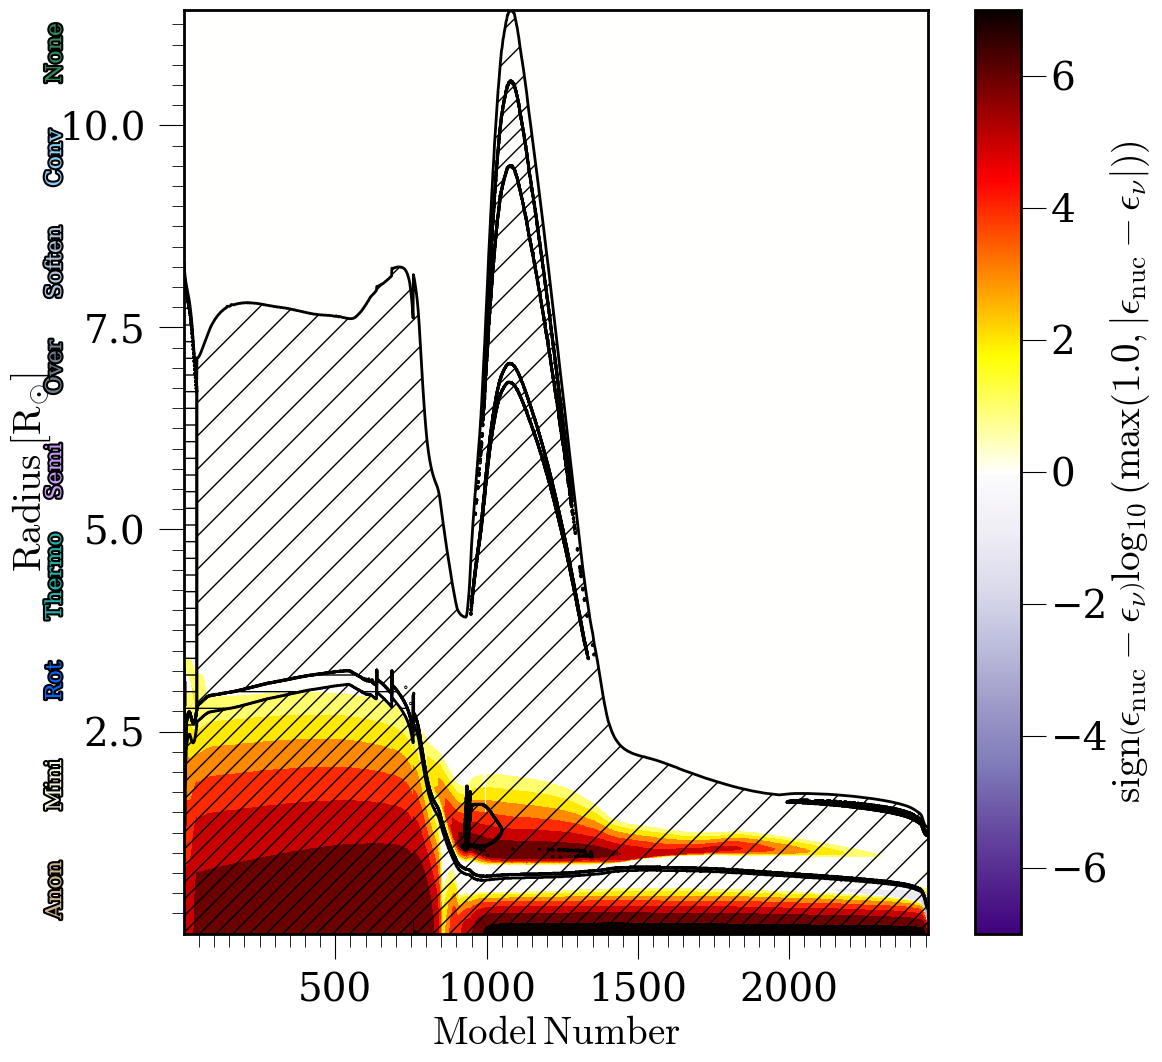

In [29]:
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, yaxis='radius')

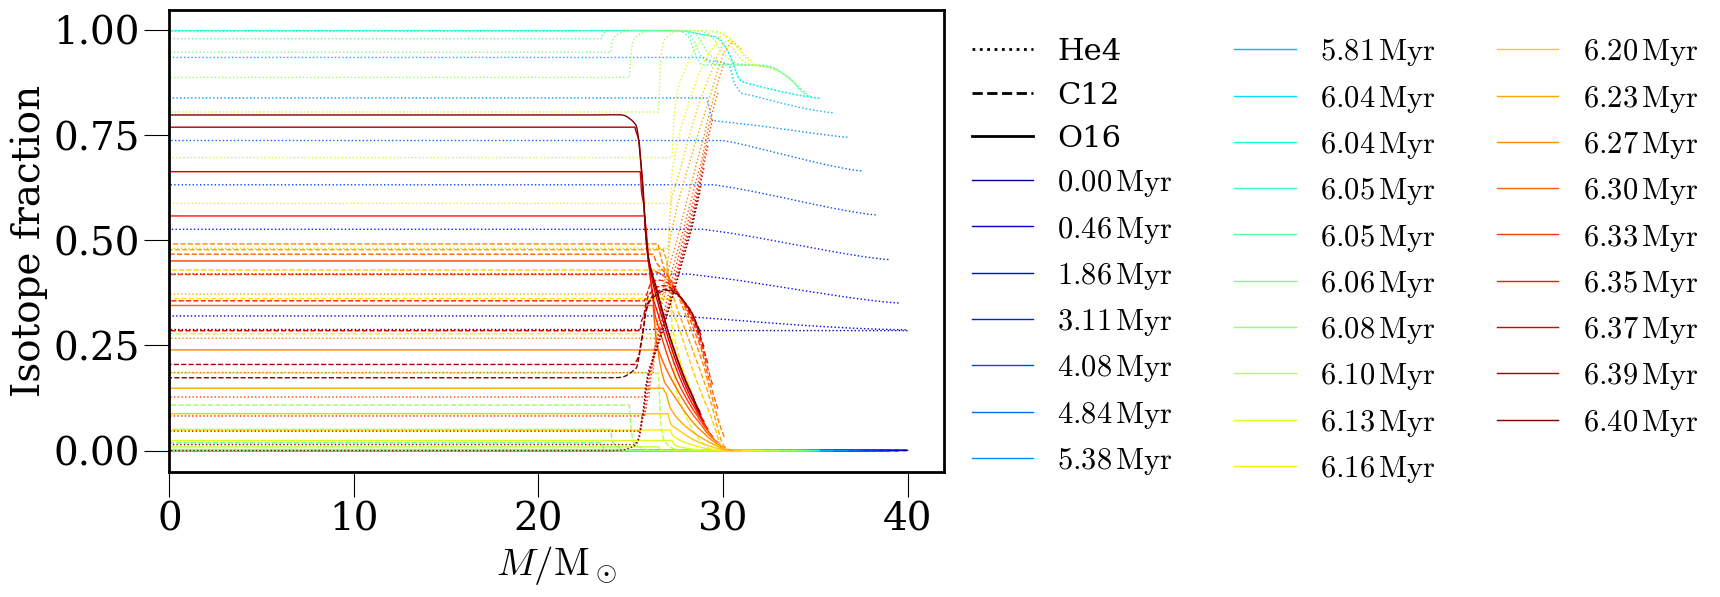

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.o16, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1, ls='-')
    ax.plot(prof.mass, prof.c12, c=c, lw=1, ls='--')
    ax.plot(prof.mass, prof.he4, c=c, lw=1, ls=':')

handles, labels  = ax.get_legend_handles_labels()
handles = handles[::-1]
handles.append(Line2D([], [], color='k', linestyle='-', label='O16'))
handles.append(Line2D([], [], color='k', linestyle='--', label='C12'))
handles.append(Line2D([], [], color='k', linestyle=':', label='He4'))
ax.legend(handles=handles[::-1], loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('Isotope fraction')
ax.set_xlim(0)
    
savefig(fig, 'abundances')

(0.0, 39.366813132519106)

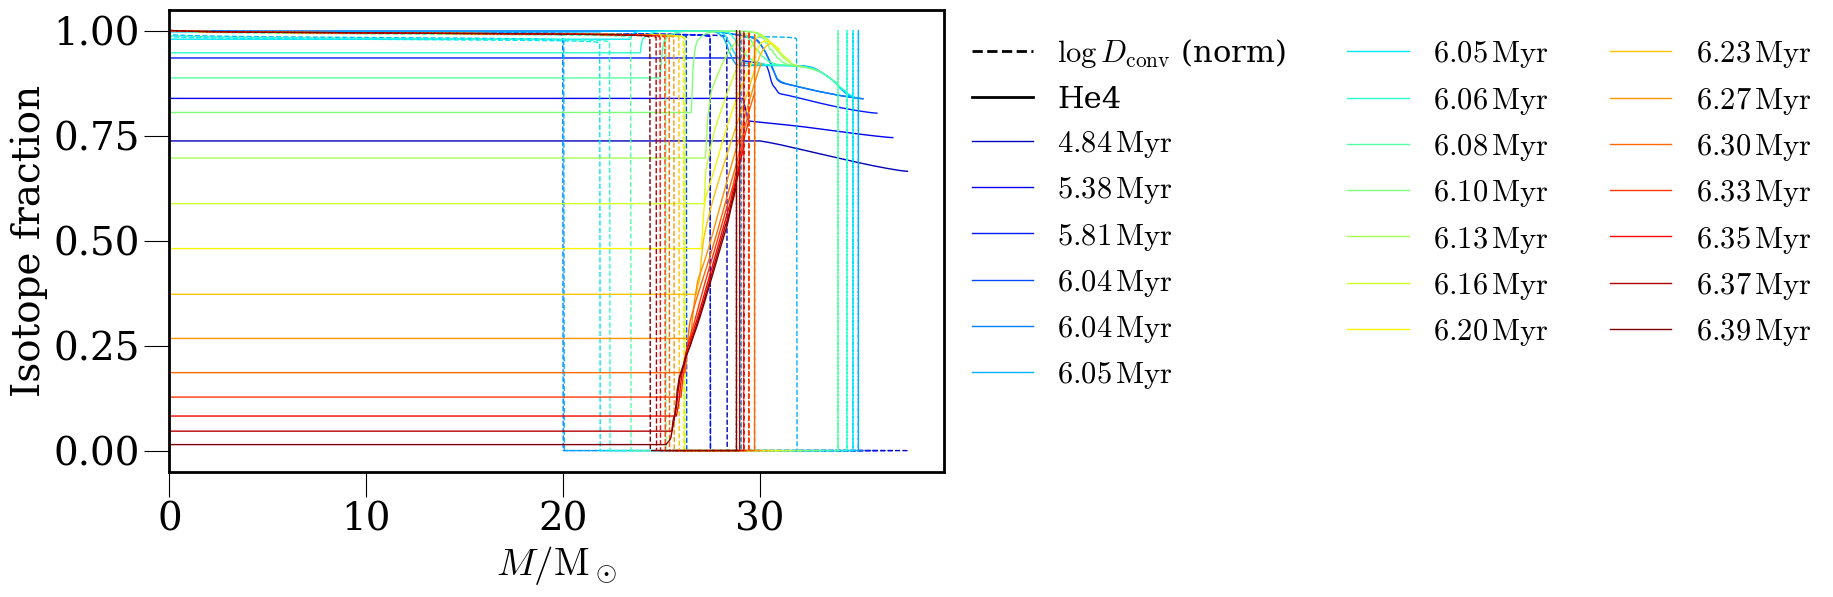

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

mini = 5
maxi = 25
for n in profile_numbers[mini:maxi]:
    c = cm.jet((n-mini)/len(profile_numbers[mini:maxi]))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.he4, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1, ls='-')
    ax.plot(prof.mass, normarr(prof.log_D_conv), c=c,lw=1, ls='--')    

handles, labels  = ax.get_legend_handles_labels()
handles = handles[::-1]
handles.append(Line2D([], [], color='k', linestyle='-', label='He4'))
handles.append(Line2D([], [], color='k', linestyle='--', label='$\\log D_\\mathrm{conv}$ (norm)'))
ax.legend(handles=handles[::-1], loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('Isotope fraction')
ax.set_xlim(0)
#ax.set_ylim(0.6)
    

(0.0, 36.99789878396478)

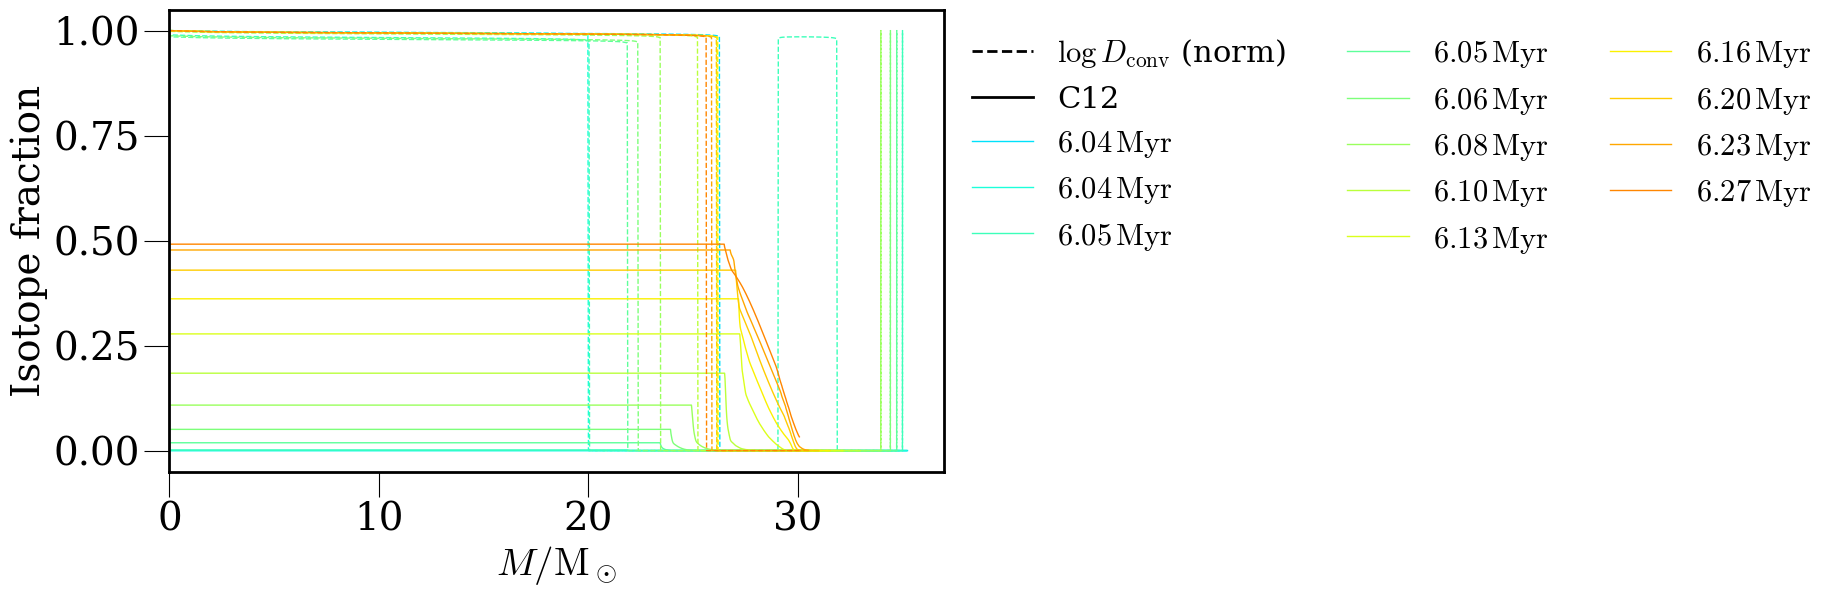

In [32]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[8:20]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.c12, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1, ls='-')
    ax.plot(prof.mass, normarr(prof.log_D_conv), c=c,lw=1, ls='--')    

handles, labels  = ax.get_legend_handles_labels()
handles = handles[::-1]
handles.append(Line2D([], [], color='k', linestyle='-', label='C12'))
handles.append(Line2D([], [], color='k', linestyle='--', label='$\\log D_\\mathrm{conv}$ (norm)'))
ax.legend(handles=handles[::-1], loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('Isotope fraction')
ax.set_xlim(0)
    

(0.0, 33.76564315810677)

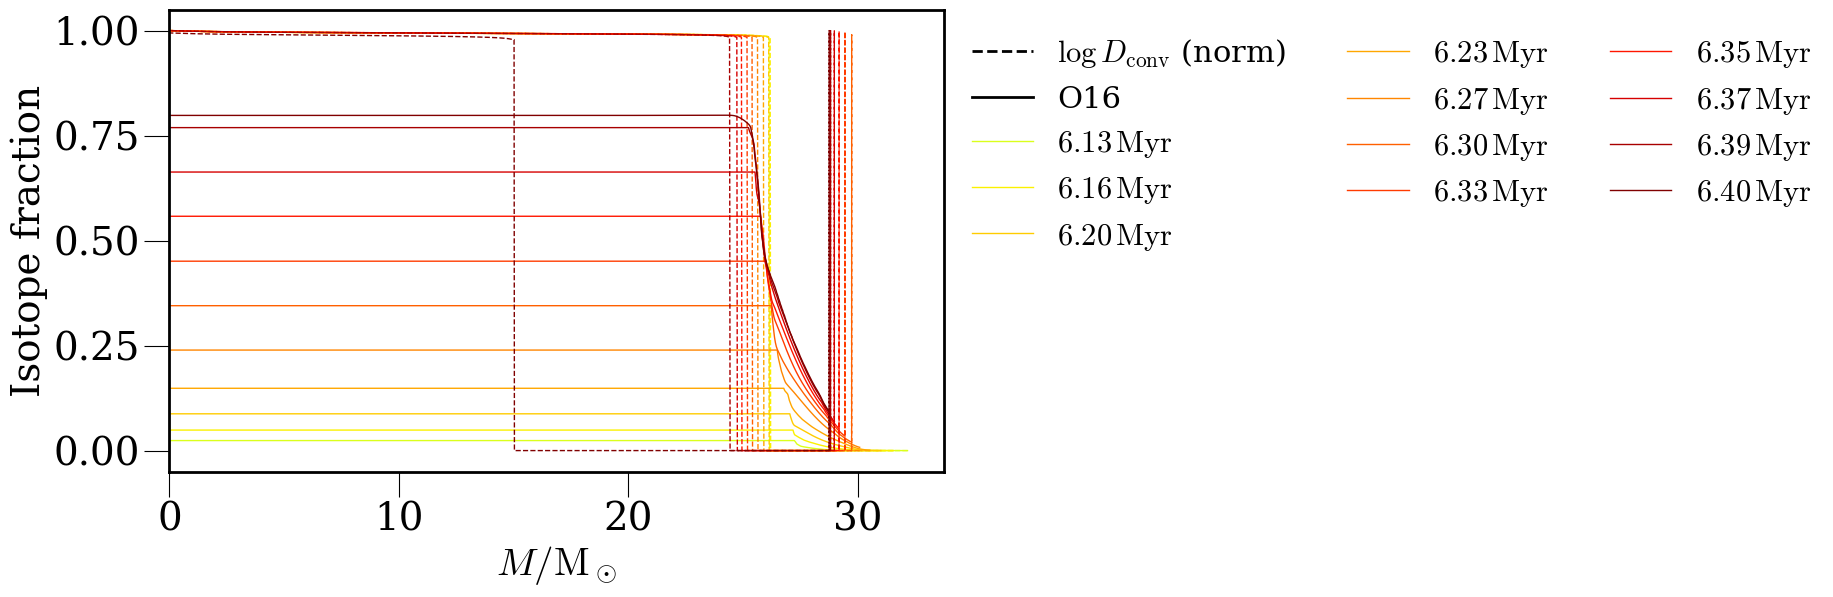

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[15:]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.o16, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1, ls='-')
    ax.plot(prof.mass, normarr(prof.log_D_conv), c=c,lw=1, ls='--')    

handles, labels  = ax.get_legend_handles_labels()
handles = handles[::-1]
handles.append(Line2D([], [], color='k', linestyle='-', label='O16'))
handles.append(Line2D([], [], color='k', linestyle='--', label='$\\log D_\\mathrm{conv}$ (norm)'))
ax.legend(handles=handles[::-1], loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('Isotope fraction')
ax.set_xlim(0)
    

(0.0, 41.99999854682715)

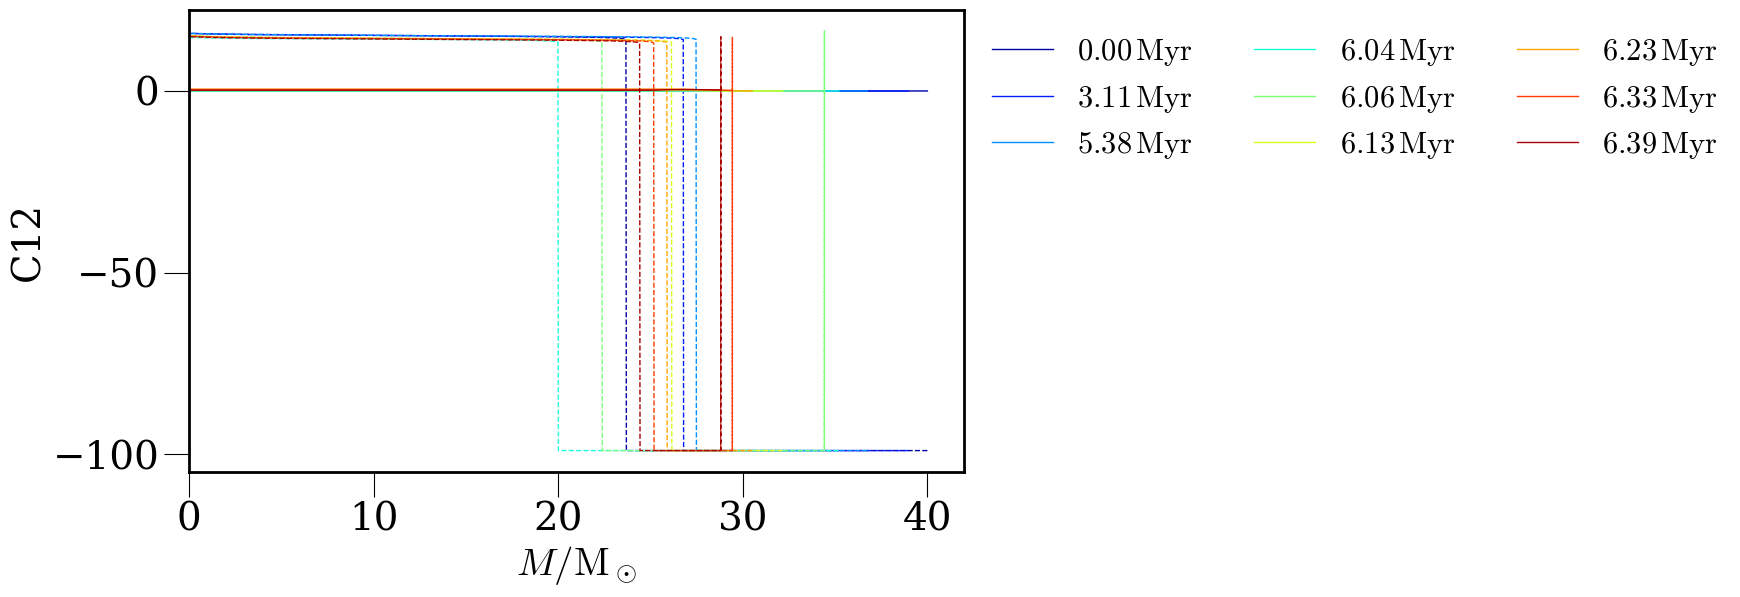

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers[::3]:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.c12, c=c, label=f'${prof.star_age/1e6:.2f}\\,\\mathrm{{Myr}}$', lw=1, ls='-')
    ax.plot(prof.mass, prof.log_D_conv, c=c,lw=1, ls='--')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('C12')
#ax.set_ylim(15, 20)
ax.set_xlim(0)
    

In [35]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [36]:
print(get_core_mass_spin_w(logs, 'h1'))
print(get_core_mass_spin_w(logs, 'he4'))
print(get_core_mass_spin_w(logs, 'c12'))
print(get_core_mass_spin_w(logs, 'ne20'))
print(get_core_mass_spin_w(logs, 'o16'))

(39.99999868611066, 7.100406361489564e-152, 0.0)
(28.997983557017555, 3.980654381419818, 0.00027254973930120724)
(26.504001826166178, 2.253703751054088, 0.00036370868542011527)
(25.198287552620915, 1.7943404074020164, 0.0007120105623122362)
(24.98014217562174, 1.7848362499713086, 0.0007154552204515961)


Now, overall,

In [37]:
models_to_plot = [0, 1, 2, 3]
model_dict_list = model_dicts[models_to_plot]

In [38]:
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
print(all_periods)

['0.73' '0.80' '0.90' '1.00' '1.10' '1.19']


In [39]:
core_def_iso = 'o16'

p_plot = np.zeros((len(model_dict_list), len(all_periods), 3))
for j, p_key in enumerate(all_periods):
    print(f'Working for p={p_key}')
    p = float(p_key)    
    for i, dict_ in enumerate(model_dict_list):
        m_key = list(dict_.keys())[0]
        print(f'Working for m={m_key}')
        model_path = dict_[m_key][p_key]
        logs = mr.MesaLogDir(str(model_path/'LOGS'))
        final_h1_cntr = logs.profile_data(profile_number=logs.profile_numbers[-1]).h1[-1]
        if final_h1_cntr > 1e-7:
            print(f'Not CHE! m={m_key}, p={p_key}')
            p_plot[i, j] = [np.nan, np.nan, np.nan]    
        else:
            mass, spin, w = get_core_mass_spin_w(logs, core_def_iso)
            p_plot[i, j] = [mass, spin, w]    
        

Working for p=0.73
Working for m=40.0


Working for m=50.0
Working for m=60.0
Working for m=70.0
Not CHE! m=70.0, p=0.73
Working for p=0.80
Working for m=40.0
Not CHE! m=40.0, p=0.80
Working for m=50.0
Working for m=60.0
Working for m=70.0
Working for p=0.90
Working for m=40.0
Not CHE! m=40.0, p=0.90
Working for m=50.0
Working for m=60.0
Working for m=70.0
Working for p=1.00
Working for m=40.0
Not CHE! m=40.0, p=1.00
Working for m=50.0
Not CHE! m=50.0, p=1.00
Working for m=60.0
Working for m=70.0
Working for p=1.10
Working for m=40.0
Not CHE! m=40.0, p=1.10
Working for m=50.0
Not CHE! m=50.0, p=1.10
Working for m=60.0
Working for m=70.0
Working for p=1.19
Working for m=40.0
Not CHE! m=40.0, p=1.19
Working for m=50.0
Not CHE! m=50.0, p=1.19
Working for m=60.0
Not CHE! m=60.0, p=1.19
Working for m=70.0


Text(0, 0.5, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

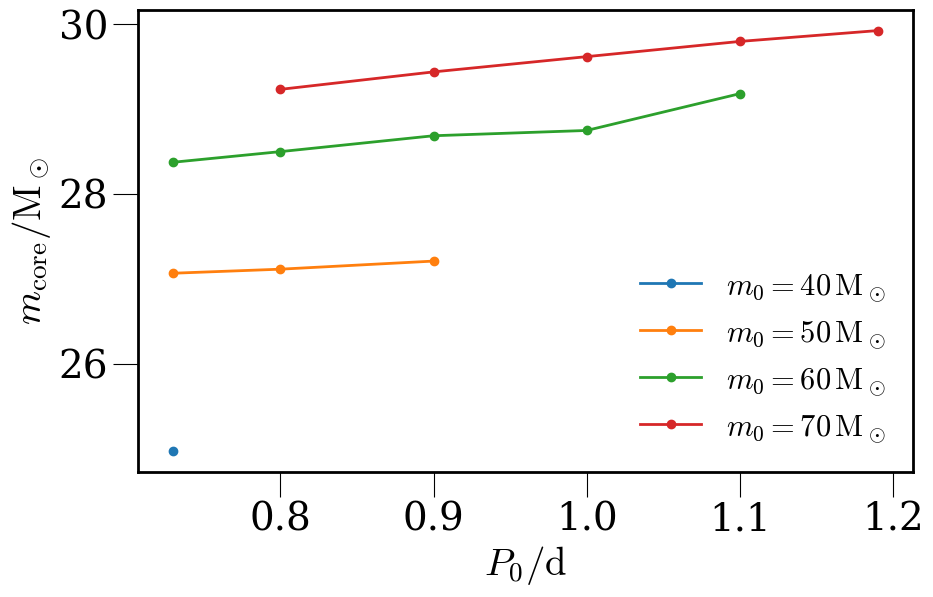

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    m = float(list(dict_.keys())[0])
    ps = np.array(all_periods, np.float32)
    ax.plot(ps, p_plot[i,:,0], label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', marker='o')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
    

Text(0, 0.5, '$\\chi_\\mathrm{core}$')

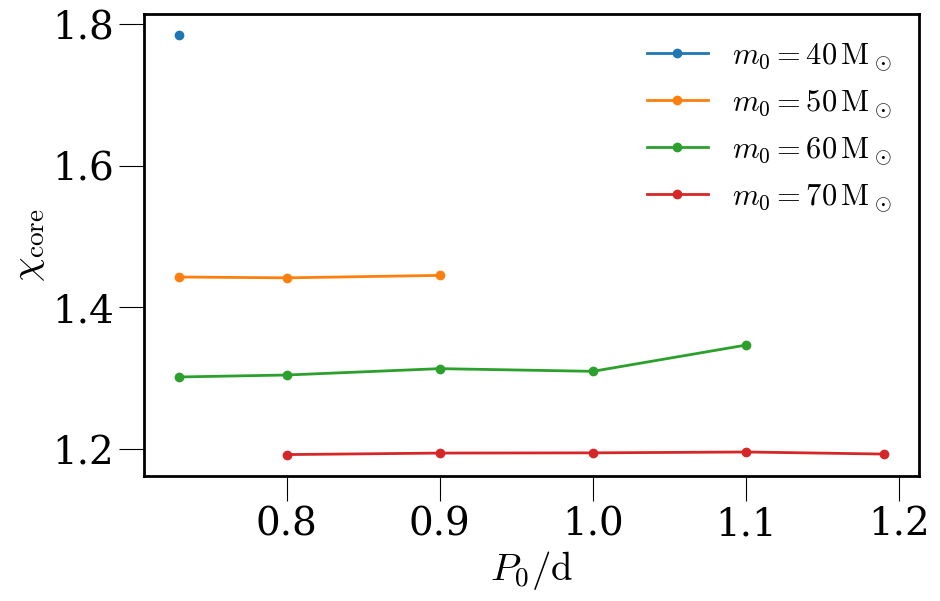

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    m = float(list(dict_.keys())[0])
    ps = np.array(all_periods, np.float32)
    ax.plot(ps, p_plot[i,:,1], label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', marker='o')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$\chi_\\mathrm{core}$')
    

Text(0, 0.5, '$m_\\mathrm{final}/m_0$')

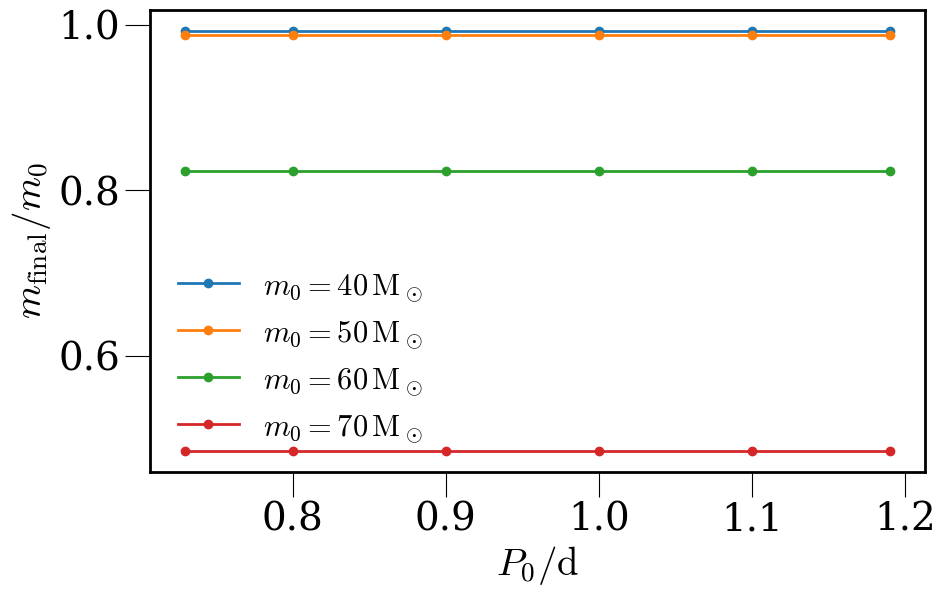

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    m_f = []
    for p in all_periods:
        h = mr.MesaData(str(dict_[m_key][p_key]/'LOGS/history.data'))
        m_f.append(h.star_mass[-1])
    m_f = np.array(m_f)
    ax.plot(ps, m_f/m, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', marker='o')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{final}/m_0$')
    

Text(0, 0.5, '$10^{3} P_\\mathrm{core}/P_0$')

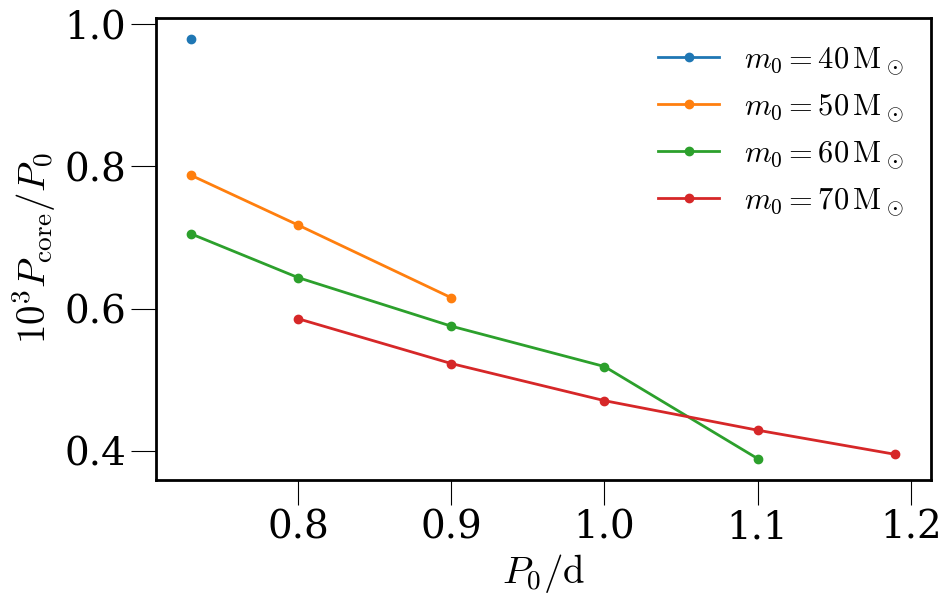

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    m = float(list(dict_.keys())[0])
    ps = np.array(all_periods, np.float32)
    ax.plot(ps, 1e3*p_plot[i,:,2]/ps, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', marker='o')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$10^{3} P_\\mathrm{core}/P_0$')
    

### Winds

Text(0, 0.5, '$\\log\\dot{M}$')

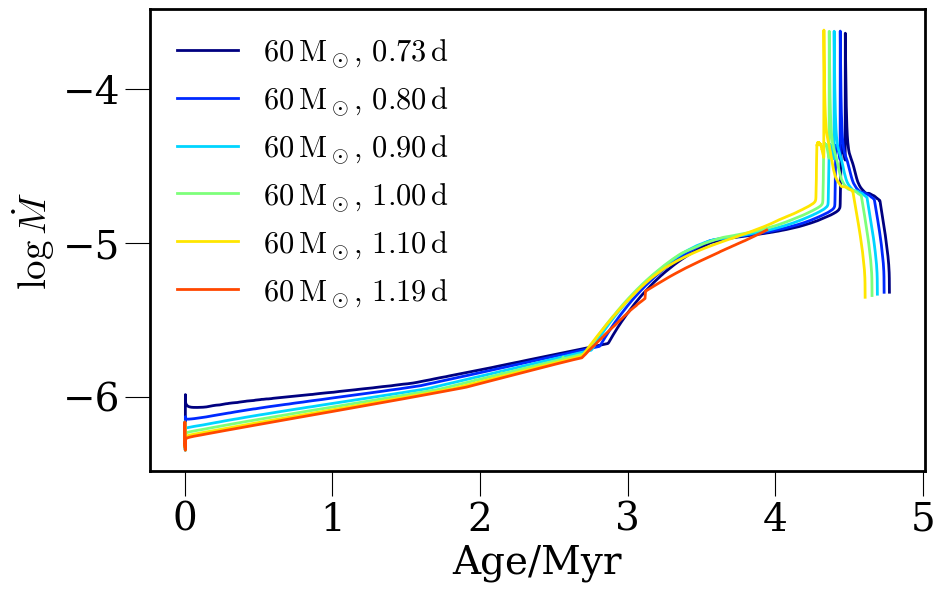

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[2]['60.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age/1e6, 
        h.log_abs_mdot, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log\\dot{M}$')

Text(0, 0.5, '$\\log L$')

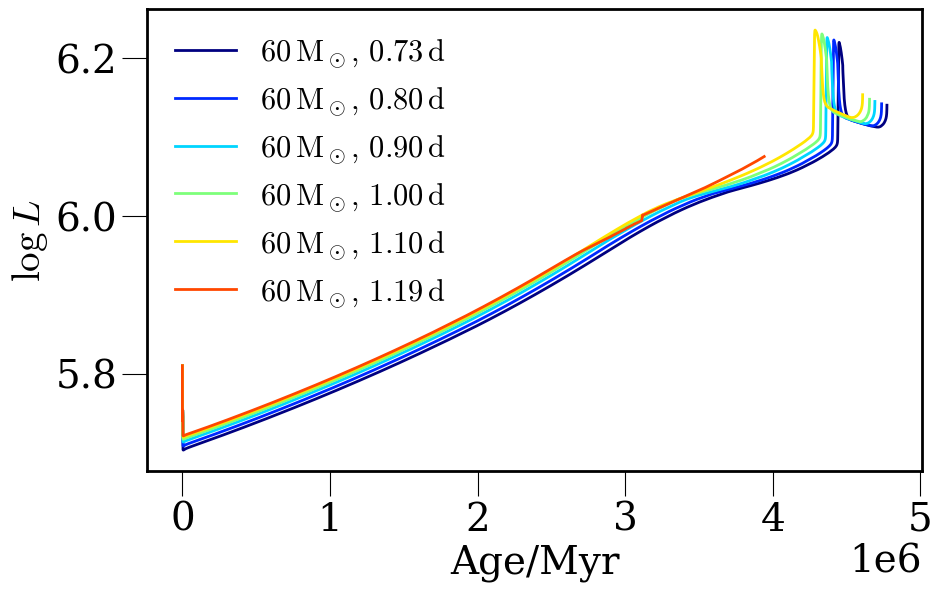

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[2]['60.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age, 
        h.log_L, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log L$')

Text(0, 0.5, '$\\log T_\\mathrm{eff}$')

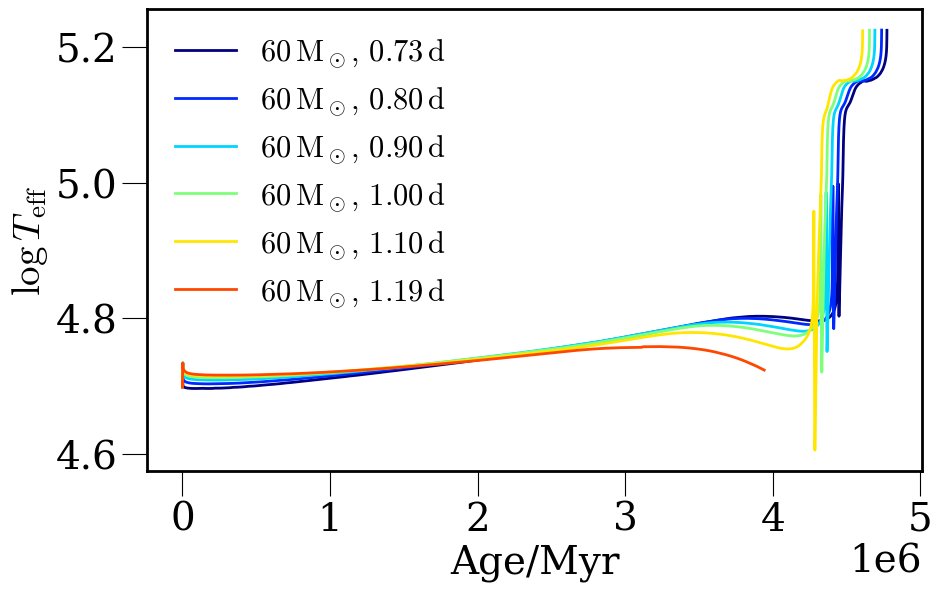

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[2]['60.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age, 
        h.log_Teff, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log T_\\mathrm{eff}$')

Text(0.5, 0, '$\\log L$')

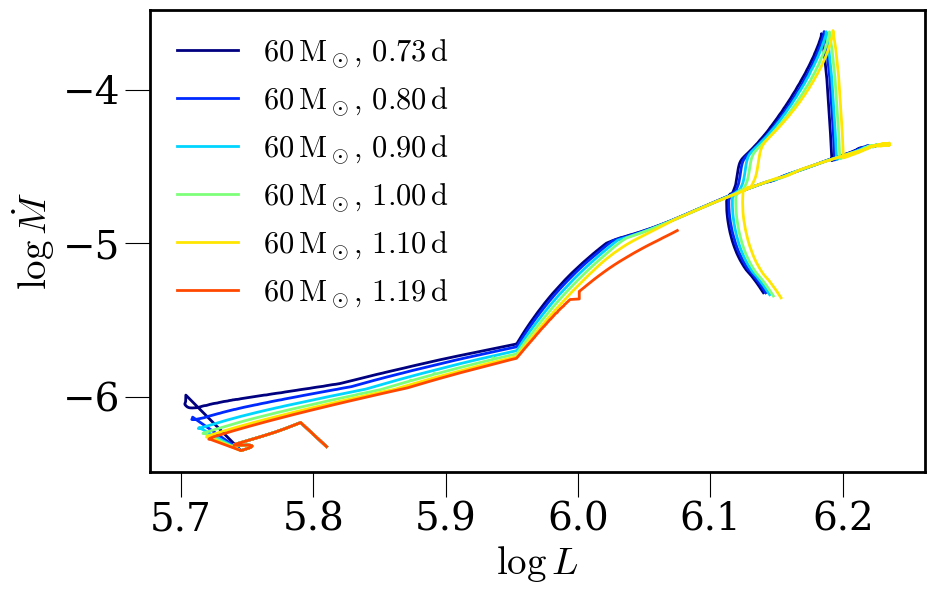

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[2]['60.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.log_L, 
        h.log_abs_mdot, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False)
ax.set_ylabel('$\\log\\dot{M}$')
ax.set_xlabel('$\\log L$')

Text(0.5, 0, '$\\log T_\\mathrm{eff}$')

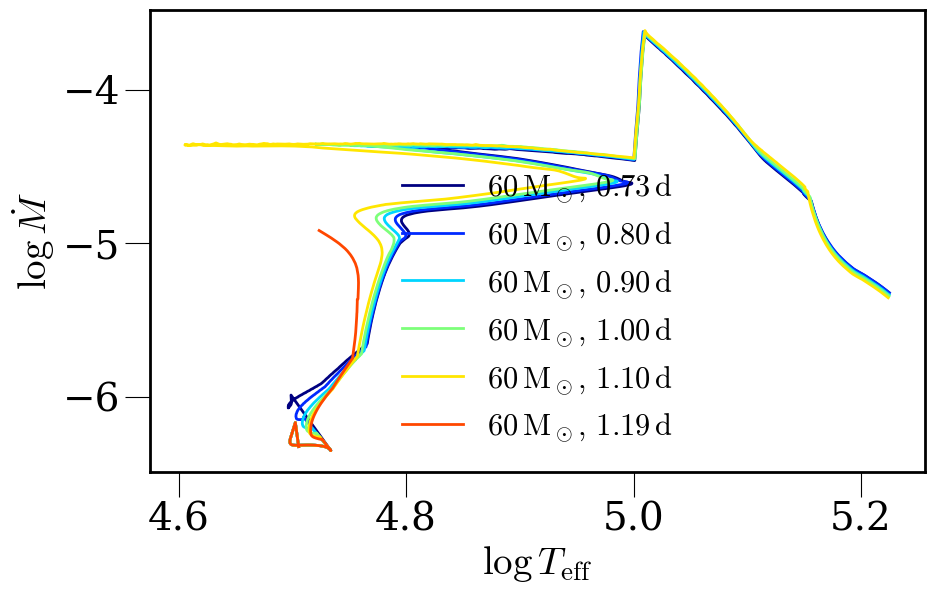

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[2]['60.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.log_Teff, 
        h.log_abs_mdot, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False)
ax.set_ylabel('$\\log\\dot{M}$')
ax.set_xlabel('$\\log T_\\mathrm{eff}$')

(-7.103290881424401, -3.5)

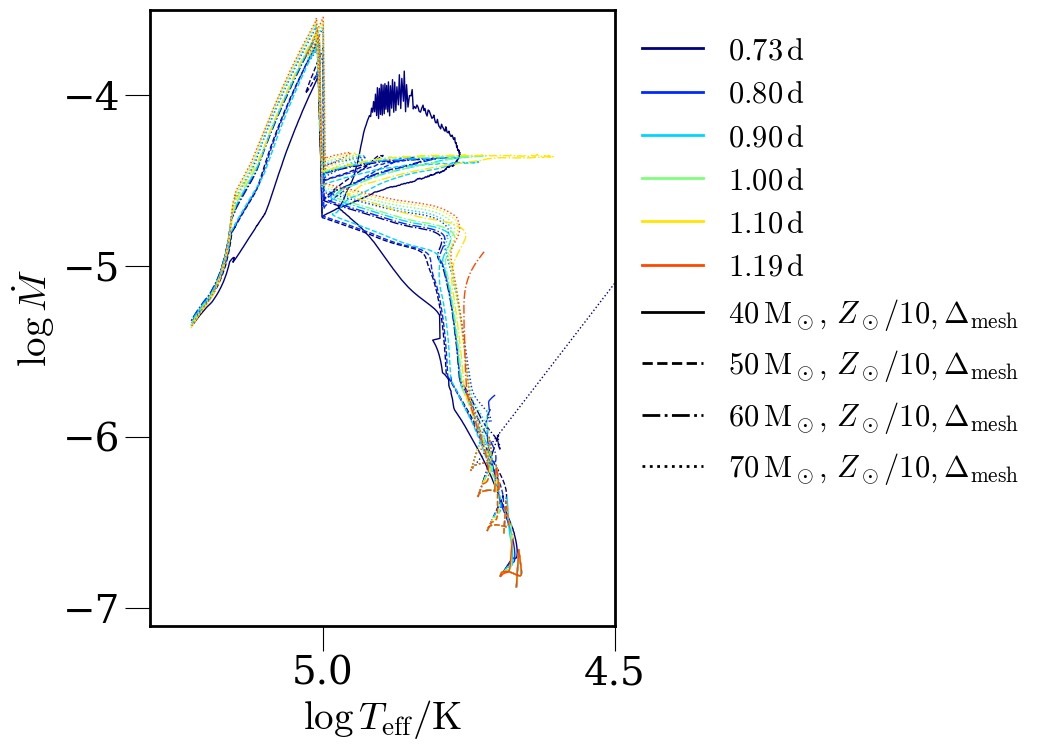

In [49]:

fig, ax = plt.subplots(figsize=(6, 8))

# Plot 1, Zsun/10

models_to_plot = [0, 1, 2, 3]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', '-.', ':']

settings = dict(
    x='log_Teff',
    y='log_abs_mdot',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log \\dot{M}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], 4.5)
ax.set_ylim(ylim[0], -3.5)


In [50]:
np.log10(1e3*(61.2e0 + 2.59e0*(-13.636e0 + 0.889e0*np.log10(0.1))))

4.372548405213902

In [51]:
wind_test_model = model_dicts[2]['60.0']['1.00']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014/10

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_t, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

In [52]:
wind_test_t

array([ 52641.84528621,  52631.88680272,  52617.44303621, ...,
       167558.81466   , 167665.07666881, 167762.22885496])

/tmp/ipykernel_1260114/3179152259.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1260114/3179152259.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


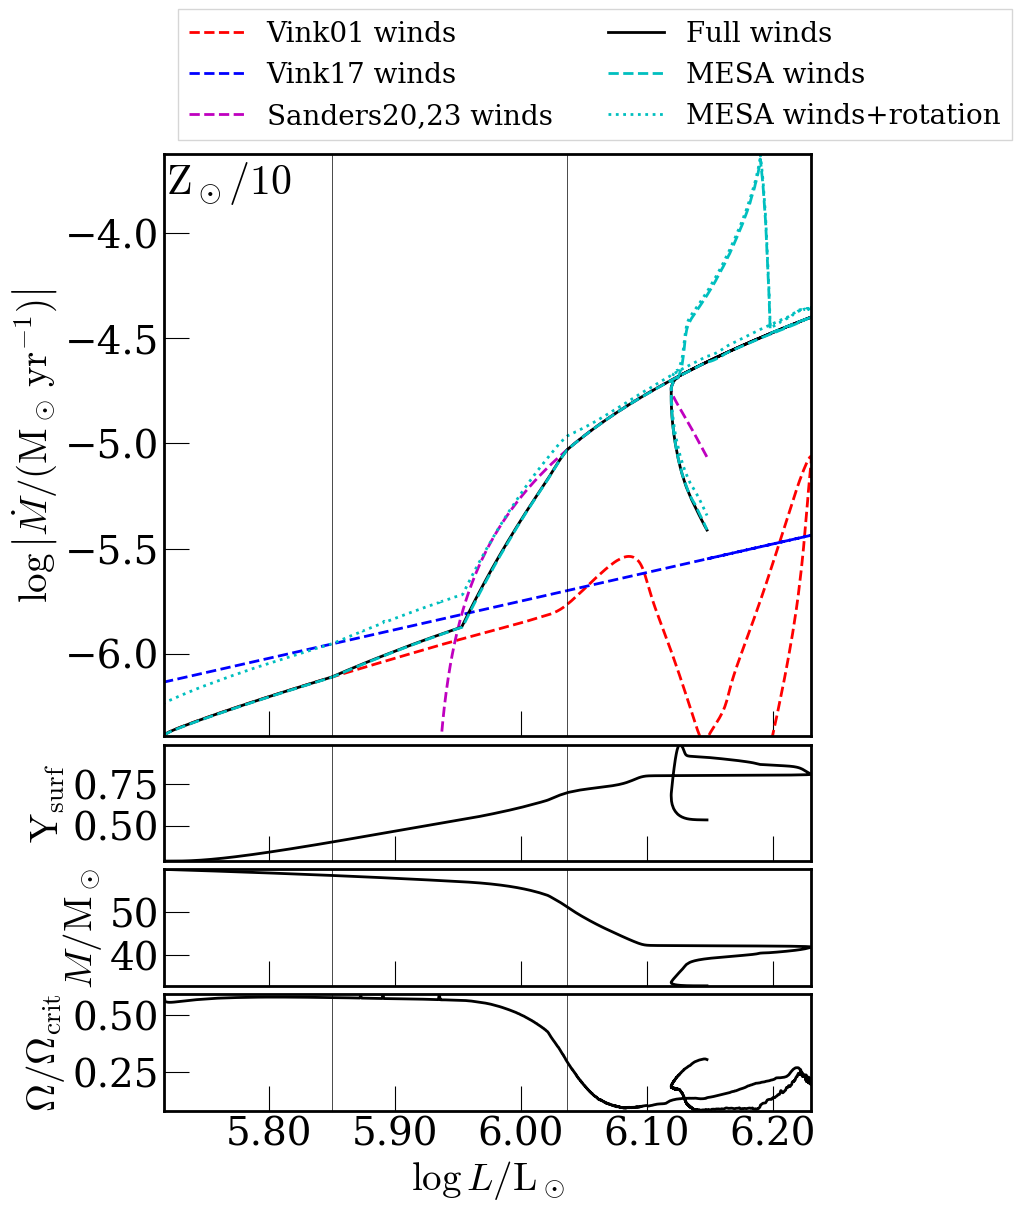

In [53]:

fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m65_p080_zsun_div_10')

In [54]:
wind_test_model = model_dicts[2]['60.0']['1.10']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014/10

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

TypeError: _sanders_winds() missing 1 required positional argument: 'z'

/tmp/ipykernel_325143/3179152259.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_325143/3179152259.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


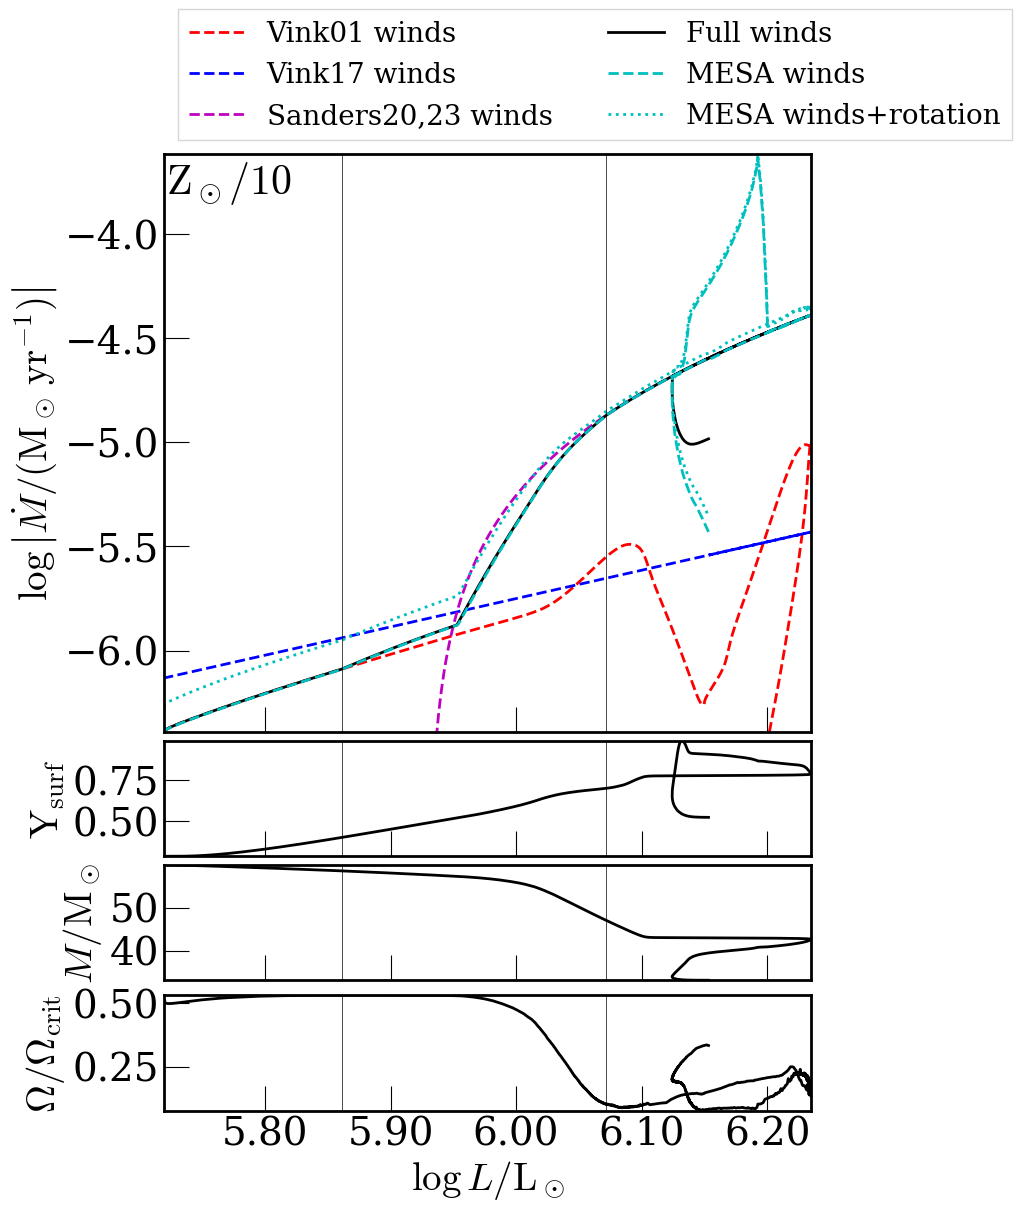

In [ ]:

fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m65_p080_zsun_div_10')

### Orbital evolution

In [ ]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

Reached end of model at t=6.40 Myr
Reached end of model at t=5.47 Myr
Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model at t=0.00 Myr
Reached end of model at t=4.33 Myr
Reached end of model at t=4.29 Myr
Reached end of model at t=4.26 Myr
Reached end of model at t=4.23 Myr
Reached end of model at t=4.20 Myr


Text(0, 0.5, '$10^{3} P_\\mathrm{core}/P_\\mathrm{orb,f}$')

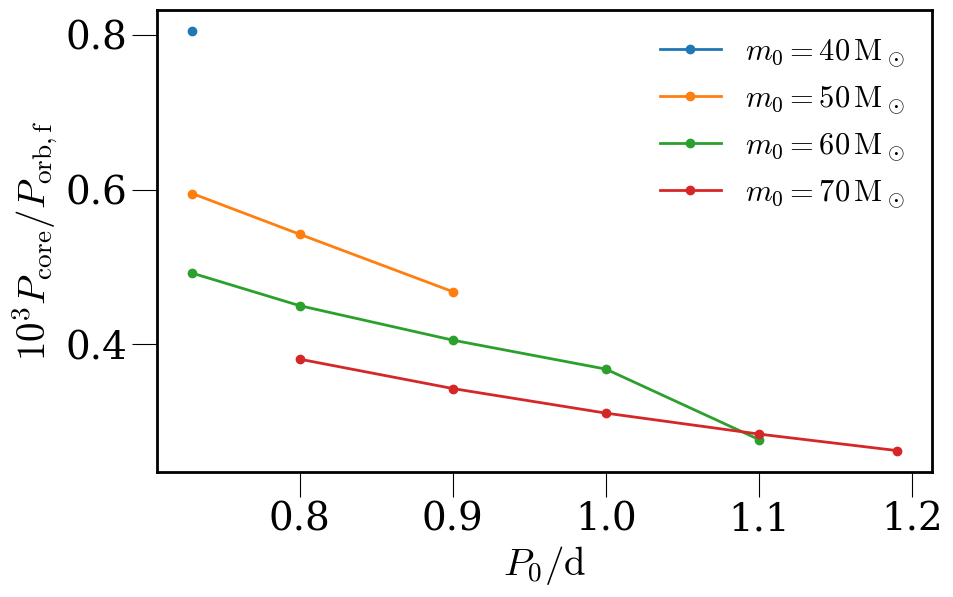

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    p_fs = []
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p_fs.append(pf)
    ax.plot(ps, 1e3*p_plot[i,:,2]/p_fs, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', marker='o')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$10^{3} P_\\mathrm{core}/P_\\mathrm{orb,f}$')
    

Reached end of model at t=6.40 Myr
Reached end of model at t=5.47 Myr
Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=6.40 Myr


/tmp/ipykernel_1965955/2438999528.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(float(p_key), pf, marker='o', c=c, s=50)


Reached end of model at t=5.47 Myr


/tmp/ipykernel_1965955/2438999528.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(float(p_key), pf, marker='x', c=c, s=50)


Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model

Text(0, 0.5, '$P_\\mathrm{orb,f}/\\mathrm{d}$')

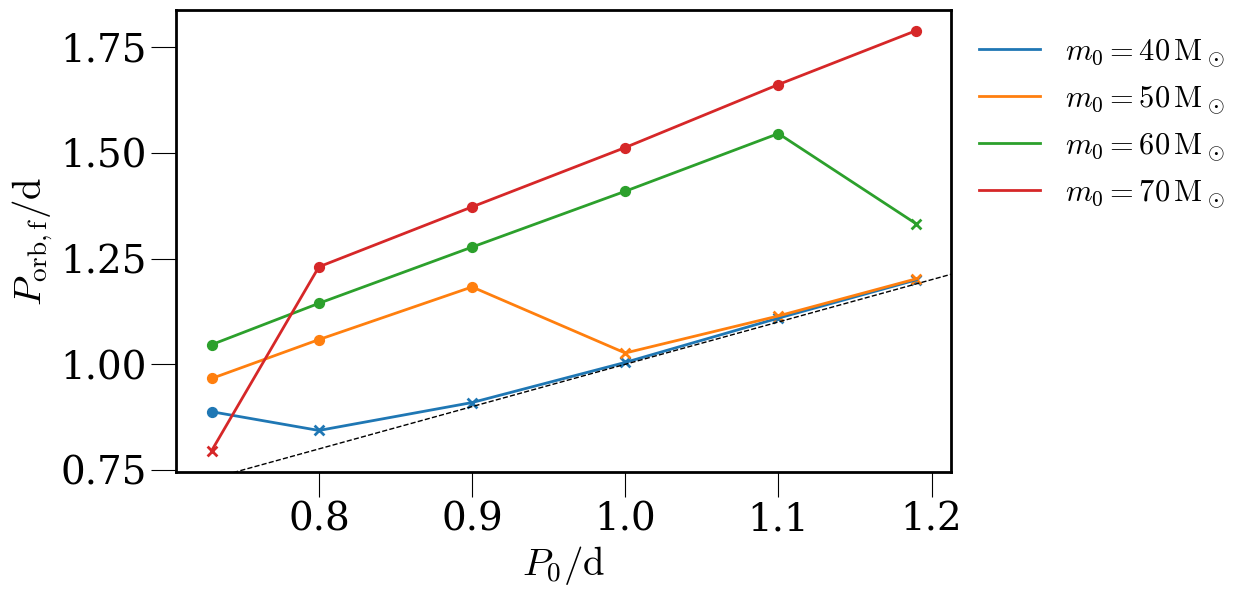

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    c = cm.tab10(i)
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    p_fs = []
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p_fs.append(pf)
    ax.plot(ps, p_fs, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', c=c)
    
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        if wi.h.center_h1[-1] <= 1e-7:
            ax.scatter(float(p_key), pf, marker='o', c=c, s=50)
        else:
            ax.scatter(float(p_key), pf, marker='x', c=c, s=50)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(np.linspace(*xlim, 10), np.linspace(*xlim, 10), 'k--', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(frameon=False, loc=('upper left'), bbox_to_anchor=(1,1))
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$P_\\mathrm{orb,f}/\\mathrm{d}$')
    

Reached end of model at t=6.40 Myr
Reached end of model at t=5.47 Myr
Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=6.40 Myr


/tmp/ipykernel_1965955/1452879144.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p, pf/p, marker='o', c=c, s=50)


Reached end of model at t=5.47 Myr


/tmp/ipykernel_1965955/1452879144.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p, pf/p, marker='x', c=c, s=50)


Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model

Text(0, 0.5, '$P_\\mathrm{orb,f}/\\mathrm{d}$')

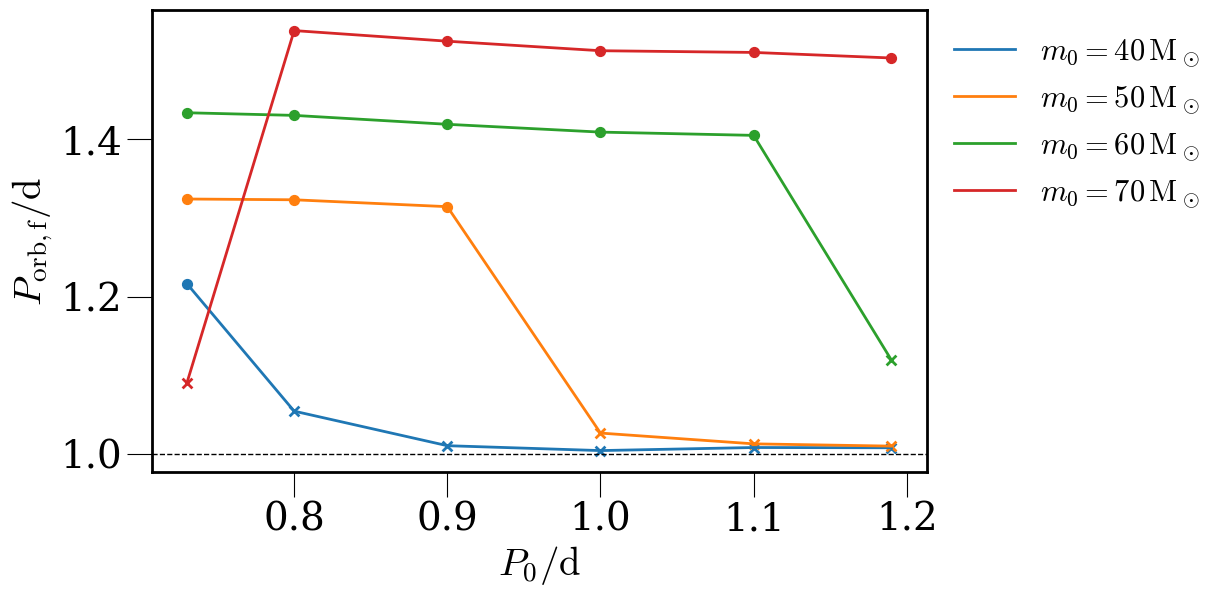

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    c = cm.tab10(i)
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    p_fs = []
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p_fs.append(pf)
    ax.plot(ps, p_fs/ps, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', c=c)
    
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p = float(p_key)
        if wi.h.center_h1[-1] <= 1e-7:
            ax.scatter(p, pf/p, marker='o', c=c, s=50)
        else:
            ax.scatter(p, pf/p, marker='x', c=c, s=50)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(np.linspace(*xlim, 10), [1]*10, 'k--', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(frameon=False, loc=('upper left'), bbox_to_anchor=(1,1))
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$P_\\mathrm{orb,f}/\\mathrm{d}$')
    

Reached end of model at t=6.40 Myr
Reached end of model at t=5.47 Myr
Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=6.40 Myr


/tmp/ipykernel_2034239/48273756.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p, pf-p, marker='o', c=c, s=50)


Reached end of model at t=5.47 Myr


/tmp/ipykernel_2034239/48273756.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p, pf-p, marker='x', c=c, s=50)


Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model

Text(0, 0.5, '$P_\\mathrm{orb,f}-P_0$')

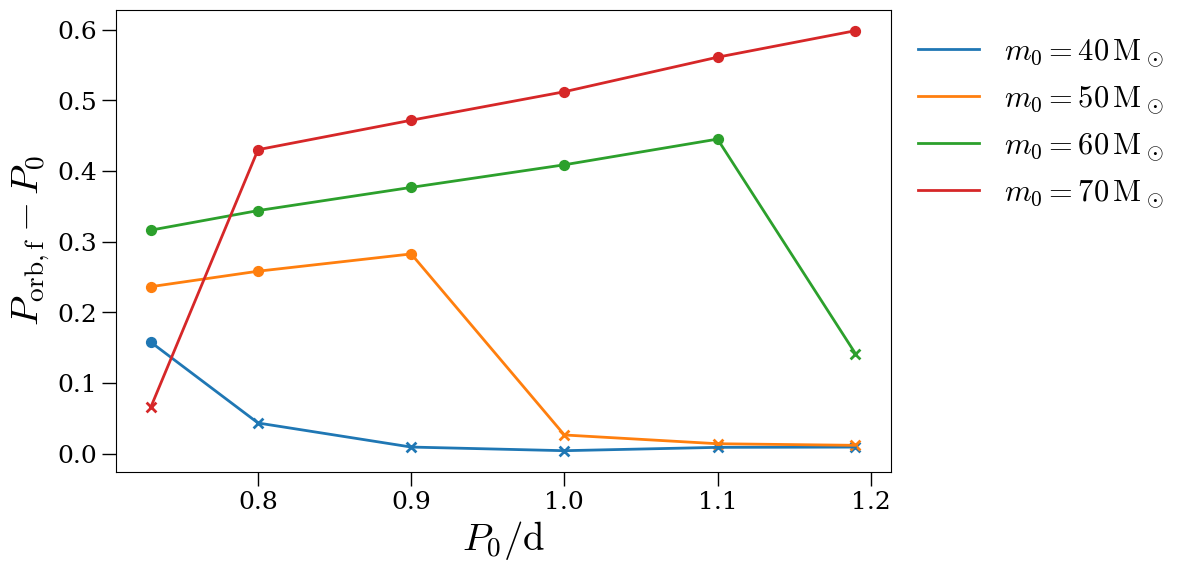

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    c = cm.tab10(i)
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    p_fs = []
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p_fs.append(pf)
    ax.plot(ps, p_fs-ps, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$', c=c)
    
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p = float(p_key)
        if wi.h.center_h1[-1] <= 1e-7:
            ax.scatter(p, pf-p, marker='o', c=c, s=50)
        else:
            ax.scatter(p, pf-p, marker='x', c=c, s=50)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(np.linspace(*xlim, 10), [1]*10, 'k--', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(frameon=False, loc=('upper left'), bbox_to_anchor=(1,1))
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$P_\\mathrm{orb,f}-P_0$')
    

Reached end of model at t=6.40 Myr
Reached end of model at t=5.47 Myr
Reached end of model at t=2.71 Myr
Reached end of model at t=1.88 Myr
Reached end of model at t=1.52 Myr
Reached end of model at t=1.41 Myr
Reached end of model at t=5.40 Myr
Reached end of model at t=5.36 Myr
Reached end of model at t=5.31 Myr
Reached end of model at t=3.44 Myr
Reached end of model at t=1.89 Myr
Reached end of model at t=1.50 Myr
Reached end of model at t=4.77 Myr
Reached end of model at t=4.74 Myr
Reached end of model at t=4.69 Myr
Reached end of model at t=4.66 Myr
Reached end of model at t=4.61 Myr
Reached end of model at t=3.94 Myr
Reached end of model at t=0.00 Myr
Reached end of model at t=4.33 Myr
Reached end of model at t=4.29 Myr
Reached end of model at t=4.26 Myr
Reached end of model at t=4.23 Myr
Reached end of model at t=4.20 Myr


Text(0, 0.5, '$\\tau_\\mathrm{tide}\\,(\\mathrm{a.u.})$')

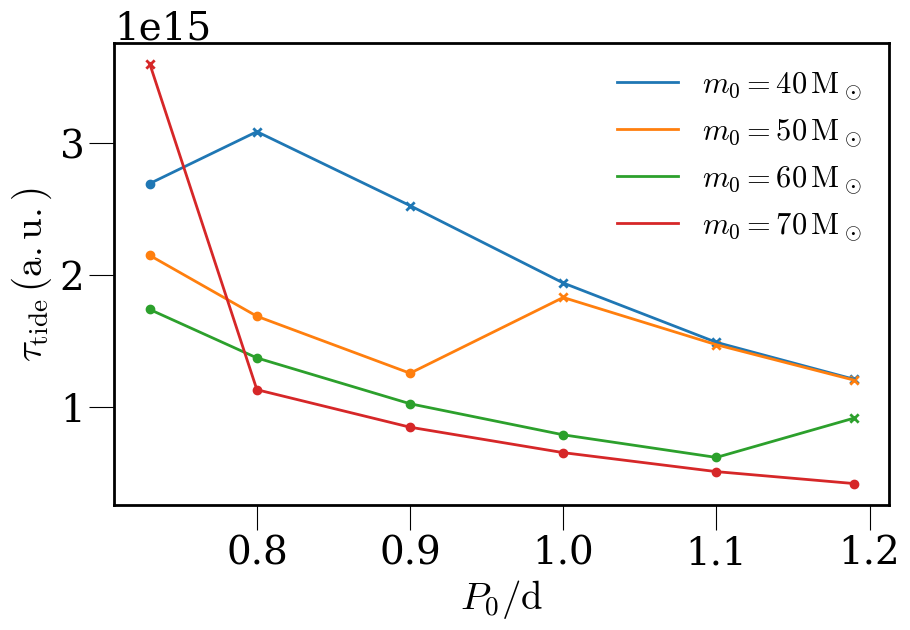

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, dict_ in enumerate(model_dict_list):
    c = cm.tab10(i)
    m_key = list(dict_.keys())[0]
    m = float(m_key)
    ps = np.array(all_periods, np.float32)
    p_fs = []
    for p_key in all_periods:
        model_path = dict_[m_key][p_key]
        wi = WindIntegrator(model_path)
        mf, pf, af, qf = wi.integrate(1e9)
        p = float(p_key)
        tidal_torque = np.abs(2*np.pi/(p*u.d.to(u.s))-2*np.pi/(pf*u.s.to(u.d)))**(8/3)        
        if wi.h.center_h1[-1] > 1e-7:
            ax.scatter(p, tidal_torque, color=c, marker='x')
        else:
            ax.scatter(p, tidal_torque, color=c, marker='o')
        p_fs.append(pf)
    p_fs = np.array(p_fs)
    tidal_torque = np.abs(2*np.pi/(ps*u.d.to(u.s))-2*np.pi/(p_fs*u.s.to(u.d)))**(8/3)
    ax.plot(ps, tidal_torque, label=f'$m_0={m:.0f}\\,\\mathrm{{M}}_\\odot$')
ax.legend(frameon=False)
ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$\\tau_\\mathrm{tide}\\,(\\mathrm{a.u.})$')
    